# Team members:

Roudranil Das, MDS202227  
Sheryan Chakraborty, MDS202237

# Importing neccessary libraries

In [96]:
# %pip install category-encoders
# %pip install tabulate
# %pip install optuna

In [97]:
import os
import time
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna # Bayesian hyperparamter optimisation

from sklearn import metrics, model_selection
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import category_encoders as ce # More efficient and powerful alternative to sklearn's categorical encoding routines

In [98]:
cmap = ["#c0affb", "#e6a176", "#5eccab", "#cdcdcd",  "#00678a", "#984464", "#c7a2a6"]
sns.set_palette(sns.color_palette(cmap))

plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['font.size'] = 18
plt.rcParams['font.family']
sns.set_style('darkgrid')

warnings.filterwarnings("ignore")

# Task 1

In [99]:
# put the appropriate path as necessary 
# df = pd.read_csv("path/bank-additional-full.csv")
df = pd.read_csv("../data/bank-additional-full.csv", sep=";")
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Preprocessing done

$\textcolor{#AED6F1}{\underline{\textbf{Client data}}}$
1. Columns to be one-hot encoded:
    - _`job`_  - Target encoding
    - _`marital`_ - Target encoding
    - _`education`_ - Target encoding
    - _`month`_ - One-Hot encoding
2. Drop _`contact`_, _`day_of_week`_ - No effect on the target variable
3. Drop _`previous`_ - Almost nobody was contacted previously 
4. Keep _`duration`_ - The model is for benchmark puproses
5. _`housing`_ and _`loan`_ - One-Hot encoding
6. Drop _`default`_ - Significant amount of unknowns

$\textcolor{#A3E4D7}{\underline{\textbf{Other data}}}$  

7. Drop _`pdays`_ - Significant amount of 999 in the colums
8. _`poutcome`_ - Ordinal encoding

$\textcolor{#F9E79F}{\underline{\textbf{Social attributes}}}$  

1. Drop - _`emp.var.rate`_ and _`nr.employed`_ - _`euribor3m`_ is highly correlated to _`emp.var.rate`_ and _`nr.employed`_

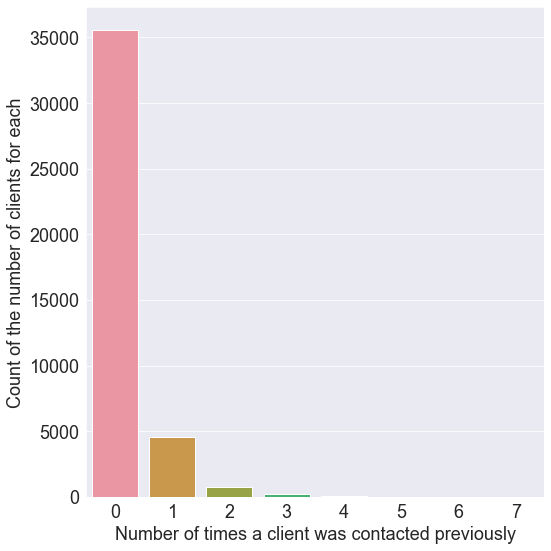

In [100]:
# how many times a person was contacted in a previous campaign
# we can see that almost 35k out of approx 41k people are new customers
sns.countplot(df, x = "previous")
plt.xlabel("Number of times a client was contacted previously")
plt.ylabel("Count of the number of clients for each")
plt.tight_layout();

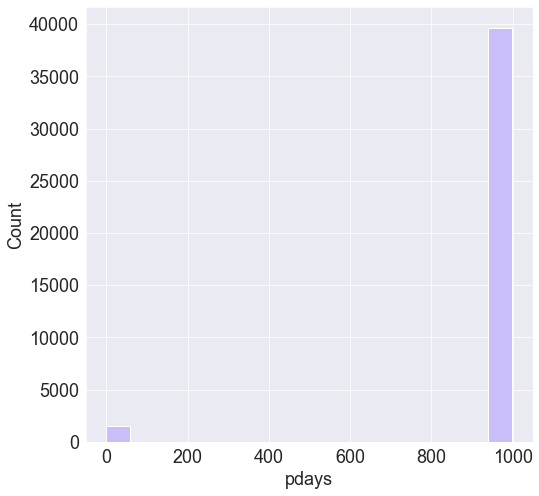

In [101]:
# Hitogram to show how many values in pdays are 999
sns.histplot(data=df, x="pdays");

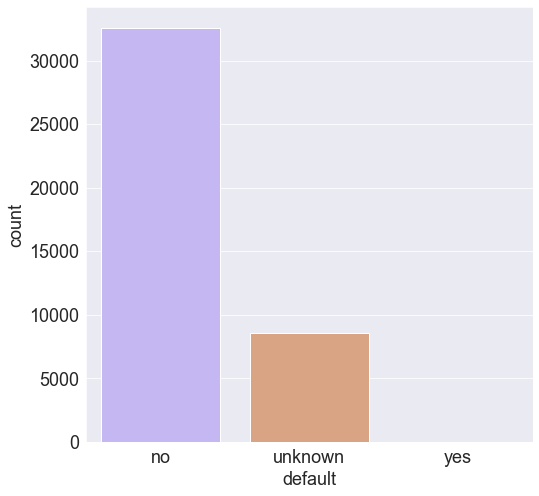

In [102]:
# significant amount of unknowns in default
sns.countplot(df, x="default");

In [103]:
# how mamy unknowns are there in all the categorical columns?
categorical_columns = [c for c in df if df[c].dtype == 'object']
numeric_columns = [c for c in df.columns if c not in categorical_columns]

def show_perc_unknown(df):
    perc = {}
    for c in categorical_columns:
        try:
            perc[c] = [
                df[c].value_counts(normalize=True)['unknown'] * 100,
                int(df[c].value_counts()['unknown']),
            ]
        except:
            perc[c] = [0, 0]

    return pd.DataFrame.from_dict(perc, orient="index", columns=["Percentage of unknown", "count of unknown"]).sort_values(by="Percentage of unknown", ascending=False)
show_perc_unknown(df)

,Percentage of unknown,count of unknown
default,20.872584,8597
education,4.202680,1731
housing,2.403613,990
loan,2.403613,990
job,0.801204,330
marital,0.194231,80
contact,0.000000,0
month,0.000000,0
day_of_week,0.000000,0
poutcome,0.000000,0


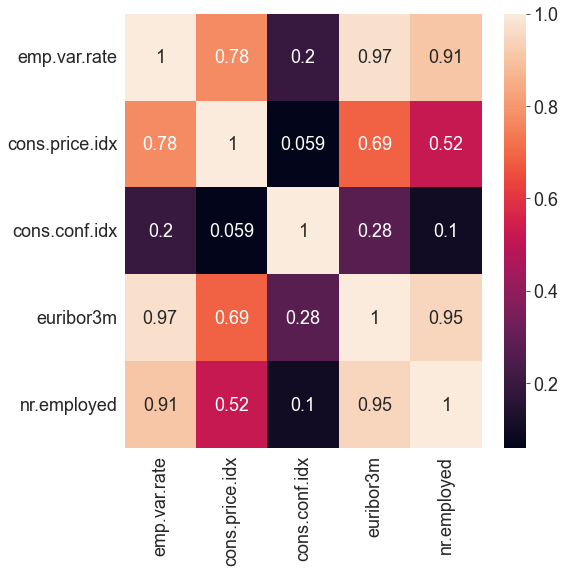

In [104]:
# correlation plot of the last 5 consumer index variables
sns.heatmap(
    df[[
        "emp.var.rate", 
        "cons.price.idx", 
        "cons.conf.idx", 
        "euribor3m",
        "nr.employed"
    ]].corr(),
    annot=True);

In [105]:
# label encoding the target
df["y"] = LabelEncoder().fit_transform(df["y"])

# correlated numerical columns
correlated_columns_to_be_dropped = ["emp.var.rate", "nr.employed"]    

# the next two functions are helper functions to simplify the preprocessing pipeline
def preprocess_both(X):
    X.drop(columns=correlated_columns_to_be_dropped, inplace=True)
    X.drop(columns=["pdays", "day_of_week", "contact", "default", "previous"], inplace=True)
    # one hot encoding
    X = pd.concat(
    [
        X.drop(columns=["housing", "loan", "month"]),
        pd.get_dummies(X[[
            "housing", "loan", "month"
        ]])
    ],
    axis=1,
    )
    # encoding poutcome
    X["poutcome"] = X["poutcome"].map({
    "failure": 1,
    "nonexistent": 2,
    "success": 3
    })

    return X

def preprocess(X_train, y_train, X_test=None):
    X_train = preprocess_both(X_train)
    X_test = preprocess_both(X_test)
    # identifier columns to indicate the presence of unknown in these columns
    for c in ["job", "marital", "education"]:
        X_train[f"{c}_is_unknown"] = X_train[c].apply(lambda x: 1 if x=="unknown" else 0)
        X_test[f"{c}_is_unknown"] = X_test[c].apply(lambda x: 1 if x == "unknown" else 0)
    # target encoding
    encoder = ce.TargetEncoder(
        ["job", "marital", "education"],
        return_df=True)
    encoder.fit(X_train, y_train)
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)

    return X_train, X_test
    


## Models

In [106]:
# evaulate the model with k-fold cross validation
def evaluate_model(model, data, params = None, n_splits = 5, task1 = True):
    clf = model(**params) if params else model()
    # trying a 5-fold cv for robust results
    skf = model_selection.StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]

    evaulation = {
        'accuracy': (metrics.accuracy_score, []),
        'recall': (metrics.recall_score, []),
        'precision': (metrics.precision_score, []),
        'f1_score': (metrics.f1_score, [])
    }
    times=[]
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train = X.loc[train_idx, :]
        X_test = X.loc[test_idx, :]

        y_train = y.loc[train_idx]
        y_test = y.loc[test_idx]
        if task1:
            X_train, X_test = preprocess(X_train, y_train, X_test)

        start_time = time.time()
        clf.fit(X_train, y_train)
        end_time = time.time()
        total_time = end_time - start_time
        times.append(total_time)
        y_pred = clf.predict(X_test)
        
        for measure in evaulation.keys():
            m, scores = evaulation[measure]
            scores.append(m(y_true=y_test, y_pred=y_pred))

    print(str(model())[:-2], "\n")
    if params:
        print("Parameters are:")
        print("".join([f"{param}: {param_val}\n" for param, param_val in params.items()]))
    print(pd.DataFrame(
        {
            m: scores for m, (_, scores) in evaulation.items()
        },
        index=[f"Fold {i}" for i in range(1, n_splits+1)]
    ), "\n")

    for measure in evaulation.keys():
        _, scores = evaulation[measure]
        print(f"{measure}: {np.mean(scores):.4f} +- {np.std(scores):.4f}\t Max: {np.max(scores):.4f}")
    print(f"\nTotal  average time taken for the model to fit is {np.mean(times)}")    

### Decision Tree

In [107]:
evaluate_model(DecisionTreeClassifier, data=df)

DecisionTreeClassifier 

        accuracy    recall  precision  f1_score
Fold 1  0.889900  0.516164   0.511206  0.513673
Fold 2  0.888080  0.518319   0.503138  0.510616
Fold 3  0.881282  0.496767   0.474280  0.485263
Fold 4  0.893651  0.538793   0.527426  0.533049
Fold 5  0.886366  0.517241   0.495868  0.506329 

accuracy: 0.8879 +- 0.0041	 Max: 0.8937
recall: 0.5175 +- 0.0133	 Max: 0.5388
precision: 0.5024 +- 0.0175	 Max: 0.5274
f1_score: 0.5098 +- 0.0153	 Max: 0.5330

Total  average time taken for the model to fit is 0.21378612518310547


#### Hyperparameter optimisation

In [108]:
# bayesian hyperparameter optimisation with optuna
def tune_hyperparam_dtree(trial):
    skf = StratifiedKFold(shuffle=True, random_state=42)
    X = df.iloc[:, :-1]
    y = df.iloc[:, [-1]]

    max_depth = trial.suggest_int("max_depth", 2, 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 6)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 2)

    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    scores = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train = X.loc[train_idx, :]
        X_test = X.loc[test_idx, :]

        y_train = y.loc[train_idx, :]
        y_test = y.loc[test_idx, :]
        X_train, X_test = preprocess(X_train, y_train, X_test)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(-metrics.accuracy_score(y_true=y_test, y_pred=y_pred))

    return np.mean(scores)

study = optuna.create_study()
start_time = time.time()
study.optimize(tune_hyperparam_dtree, n_trials = 10)
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken for hyper-parameter tuning is {total_time}")

[I 2023-02-12 23:16:06,582] A new study created in memory with name: no-name-6267cb60-5c12-4fd2-b468-4eef5923ff65
[I 2023-02-12 23:16:08,502] Trial 0 finished with value: -0.9081772382698843 and parameters: {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.9081772382698843.
[I 2023-02-12 23:16:10,370] Trial 1 finished with value: -0.9102409019422574 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.9102409019422574.
[I 2023-02-12 23:16:12,253] Trial 2 finished with value: -0.9102409019422574 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: -0.9102409019422574.
[I 2023-02-12 23:16:14,244] Trial 3 finished with value: -0.911770511394311 and parameters: {'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value: -0.911770511394311.
[I 2023-02-12 23:16:15,760] Trial 4 finished with value: -0.

Total time taken for hyper-parameter tuning is 17.37790322303772


In [109]:
params = study.best_params
evaluate_model(DecisionTreeClassifier, df, params)

DecisionTreeClassifier 

Parameters are:
max_depth: 5
min_samples_split: 4
min_samples_leaf: 2

        accuracy    recall  precision  f1_score
Fold 1  0.914542  0.521552   0.650538  0.578947
Fold 2  0.910901  0.478448   0.639769  0.547472
Fold 3  0.906288  0.483836   0.605121  0.537725
Fold 4  0.914289  0.490302   0.661337  0.563119
Fold 5  0.916839  0.536638   0.661355  0.592504 

accuracy: 0.9126 +- 0.0037	 Max: 0.9168
recall: 0.5022 +- 0.0228	 Max: 0.5366
precision: 0.6436 +- 0.0208	 Max: 0.6614
f1_score: 0.5640 +- 0.0200	 Max: 0.5925

Total  average time taken for the model to fit is 0.07810535430908203


In [110]:
params

{'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}

In [111]:
X = df.iloc[:, :-1]
y = df.iloc[:, [-1]]
clf = DecisionTreeClassifier(**params)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
X_train, X_test = preprocess(X_train, y_train, X_test)

%load_ext memory_profiler
%memit clf.fit(X_train, y_train)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 281.85 MiB, increment: 2.64 MiB


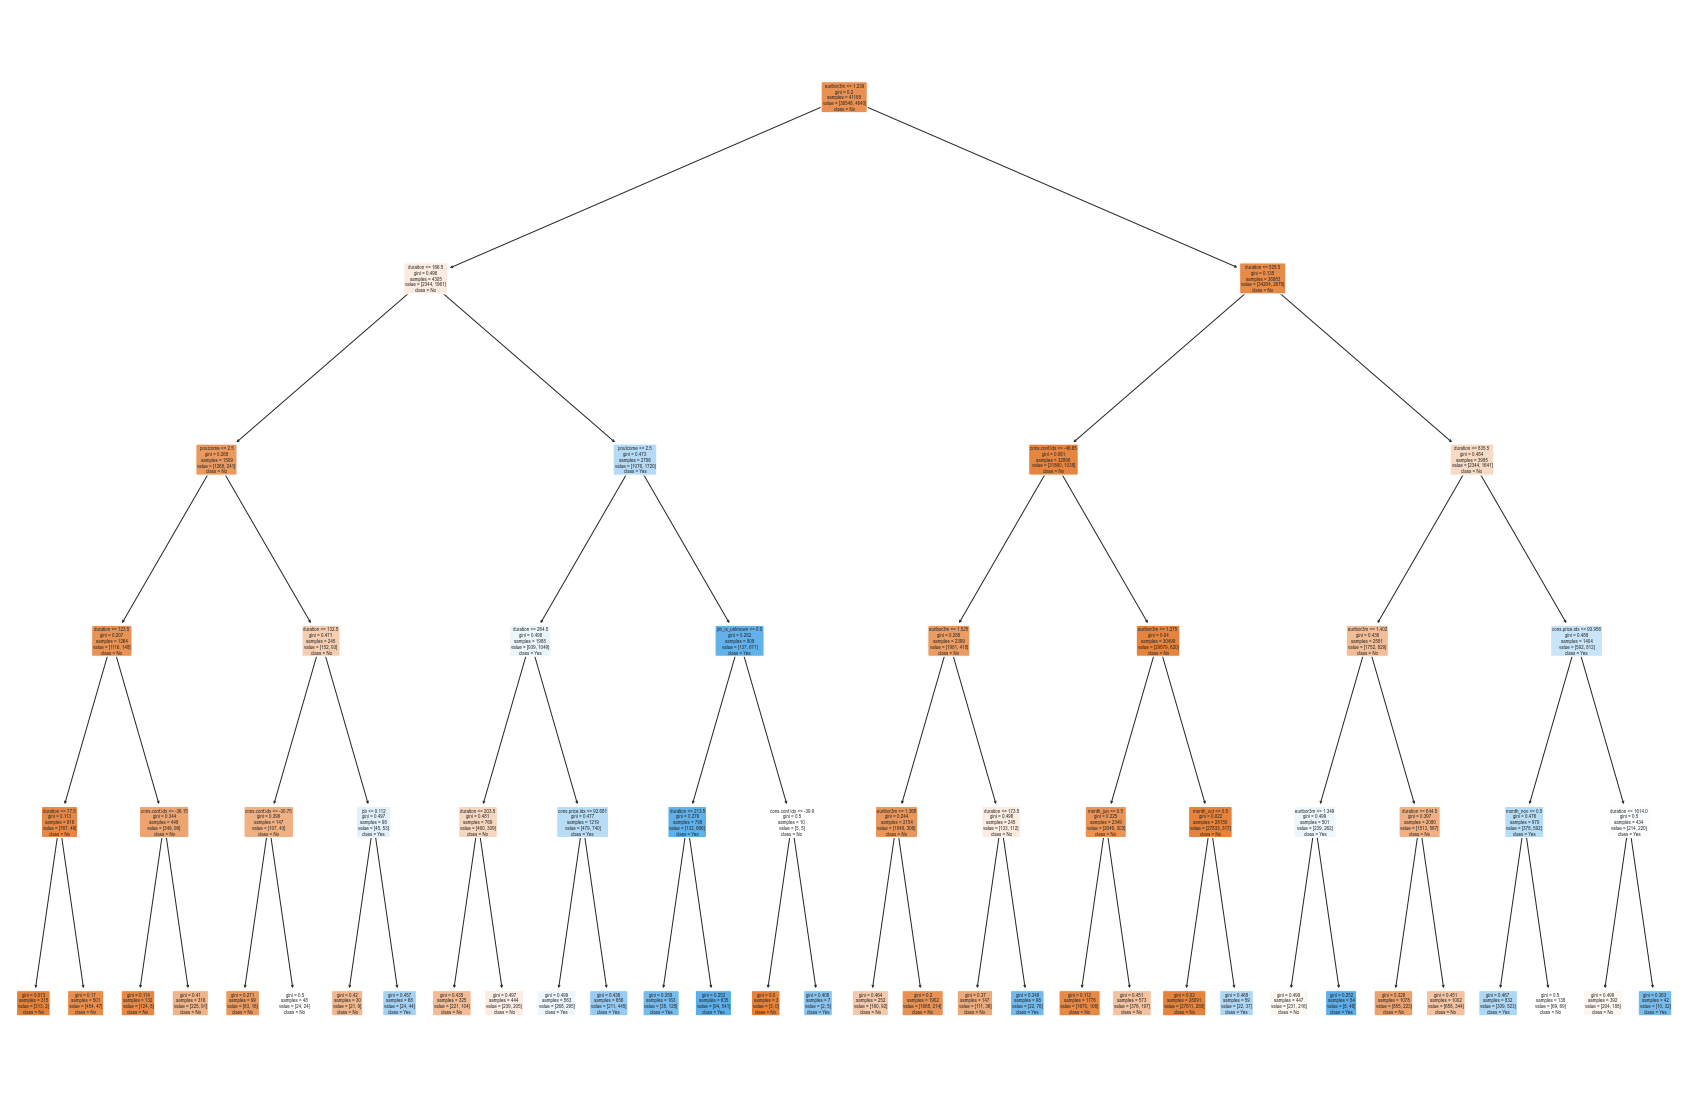

In [112]:
X = df.iloc[:, :-1]
y = df.iloc[:, [-1]]
clf = DecisionTreeClassifier(**params)
X, _ = preprocess(X, y, X.copy())
clf.fit(X, y)

classes = ["No", "Yes"]
plt.figure(figsize=(30, 20))
plot_tree(clf, filled=True, rounded=True, class_names=classes, feature_names=X.columns);

### Naive Bayes

In [113]:
evaluate_model(GaussianNB, df)

GaussianNB 

        accuracy    recall  precision  f1_score
Fold 1  0.881767  0.455819   0.474215  0.464835
Fold 2  0.877155  0.431034   0.452489  0.441501
Fold 3  0.868172  0.401940   0.412611  0.407205
Fold 4  0.877868  0.431034   0.455581  0.442968
Fold 5  0.875319  0.420259   0.443686  0.431655 

accuracy: 0.8761 +- 0.0045	 Max: 0.8818
recall: 0.4280 +- 0.0175	 Max: 0.4558
precision: 0.4477 +- 0.0202	 Max: 0.4742
f1_score: 0.4376 +- 0.0187	 Max: 0.4648

Total  average time taken for the model to fit is 0.02907900810241699


In [114]:
X = df.iloc[:, :-1]
y = df.iloc[:, [-1]]
clf = GaussianNB()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
X_train, X_test = preprocess(X_train, y_train, X_test)

%reload_ext memory_profiler
%memit clf.fit(X_train, y_train)

peak memory: 281.14 MiB, increment: 3.37 MiB


# Task 2

In [115]:
# put the appropriate path as necessary 
# df = pd.read_csv("path/bollywood-movies.csv")
dataset=pd.read_csv("../data/bollywood-movies.csv")
dataset.head(5)

,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Revenue(INR),Budget(INR)
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,5000000,85000
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,15000000,825000
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,75000000,56700000
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,210000000,4500000
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1000000,1075000


In [116]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698 entries, 0 to 1697
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Movie Name          1698 non-null   object
 1   Release Period      1698 non-null   object
 2   Whether Remake      1698 non-null   object
 3   Whether Franchise   1698 non-null   object
 4   Genre               1698 non-null   object
 5   New Actor           1698 non-null   object
 6   New Director        1698 non-null   object
 7   New Music Director  1698 non-null   object
 8   Lead Star           1698 non-null   object
 9   Director            1698 non-null   object
 10  Music Director      1698 non-null   object
 11  Number of Screens   1698 non-null   int64 
 12  Revenue(INR)        1698 non-null   int64 
 13  Budget(INR)         1698 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 185.8+ KB


## Preprocessing done

$\textcolor{#AED6F1}{\underline{\textbf{Names}}}$

The following columns contains only names:
> _`Movie Name`_, _`Lead Star`_, _`Director`_, _`Music Director`_.  

Although it is reasonable to expect that movie names, and especially directors, lead stars and music directors often dictate the success of a film, from a machine learning perspective, these columns contain nothing but categorical data with too many unique values, which will make encoding impossible:
- one hot encoding with create a highly sparse matrix with roughly 4000 columns
- ordinal encoding is not advised as there should not be any inherent ordering in names.  

We discuss further about this in the report. For the aforementioned reasons we decide to drop these columns.

$\textcolor{#A3E4D7}{\underline{\textbf{Other categorical data}}}$  

The following categorical columns had only 2 categories so we encoded them as 1 and 0:  
> _`whether remake`_, _`whether franchise`_, _`new actor`_, _`new director`_, _`new music director`_.


$\textcolor{#F9E79F}{\underline{\textbf{Number of screens}}}$  

The distribution of the number of screens is hihgly positively skewed. Hence we first min-max scale the data, and then quantile encode it:  
- if $\textit{num\_screens}\leq Q_1$ then encode it as _`low`_
- if $Q_1<\textit{num\_screens}\leq Q_3$ then encode it as _`moderate`_
- if $Q_3<\textit{num\_screens}$ then encode it as _`high`_

The resultant categorical column is then one-hot-encoded.

All other categorical columns are one-hot encoded.

In [117]:
x = dataset.iloc[:,:].values
x = pd.DataFrame(x) # done to make dealing with the column names easier
y = dataset.copy() # copy of the entire dataset, not to be mistaken as target
y.columns=y.columns.str.lower()

In [118]:
x[14] = np.where((x[12] < x[13]),1,0) # categorising movies as hit or flop
pd.DataFrame(x[14])

,14
0,0
1,0
2,0
3,0
4,1
...,...
1693,1
1694,0
1695,0
1696,0


In [119]:
# unique values in all the columns
for i in dataset.columns:
    if dataset[i].dtype == "object":
        print(i)
        print(dataset[i].unique())
        print("\n")

Movie Name
['Golden Boys' 'Kaccha Limboo' 'Not A Love Story' ...
 'Dunno Y Na Jaane Kyun' 'Taj Mahal - An Eternal Love Story'
 'Mr. Hot Mr. Kool']


Release Period
['Normal' 'Holiday']


Whether Remake
['No' 'Yes']


Whether Franchise
['No' 'Yes']


Genre
['suspense' 'drama' 'thriller' 'adult' 'comedy' 'action' 'love_story'
 'rom__com' 'horror' 'fantasy' 'masala' 'mythological' 'animation'
 'documentary']


New Actor
['Yes' 'No']


New Director
['No' 'Yes']


New Music Director
['No' 'Yes']


Lead Star
['Jeet Goswami' 'Karan Bhanushali' 'Mahie Gill' 'Aadar Jain' 'Aadil Khan'
 'Aakar Kaushik' 'Aakash' 'Aamir Bashir' 'Aamir Khan' 'Aanamika Bawa'
 'Aarun Nagar' 'Aaryan' 'Aasad Mirza' 'Aashish Chanana'
 'Aashish Chaudhary' 'Aasif Albela' 'Aatri Kumar' 'Abhay Bakshi'
 'Abhay Deol' 'Abhijeet Sawant' 'Abhinav Shukla' 'Abhishek Anand'
 'Abhishek Bachchan' 'Abhishek Gupta' 'Abhishek Sharma' 'Abhishek Urade'
 'Adah Sharma' 'Adam Bedi' 'Adhvik Mahajan' 'Adhyayan Suman'
 'Adil Hussain' 'Aditi Inam

In [120]:
# ordinal encoding of the categorical columns
y["whether remake"]=np.where((y["whether remake"]=="Yes"),1,0)
y["whether franchise"]=np.where((y["whether franchise"]=="Yes"),1,0)
y["new actor"]=np.where((y["new actor"]=="Yes"),1,0)
y["new director"]=np.where((y["new director"]=="Yes"),1,0)
y["new music director"]=np.where((y["new music director"]=="Yes"),1,0)
y.drop(["revenue(inr)","movie name","lead star","director","music director"],axis=1,inplace=True)
y.head()

,release period,whether remake,whether franchise,genre,new actor,new director,new music director,number of screens,budget(inr)
0,Normal,0,0,suspense,1,0,0,5,85000
1,Holiday,0,0,drama,1,0,1,75,825000
2,Holiday,0,0,thriller,0,0,0,525,56700000
3,Holiday,0,0,drama,1,0,0,800,4500000
4,Holiday,0,0,adult,1,1,1,1,1075000


Range of the number of screens: 4599


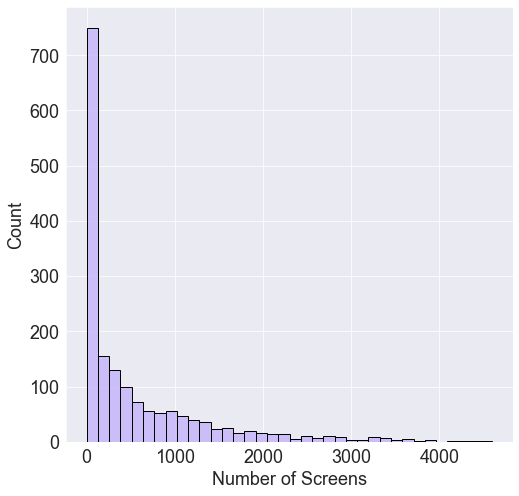

In [121]:
# dealing with the number of screens
print(f"Range of the number of screens: {max(y['number of screens'])-min(y['number of screens'])}")

sns.histplot(dataset, x="Number of Screens", edgecolor="black");

In [122]:
l=[] # mapping from num_screen -> low/moderate/high
for i in x[11]:
    if i>x[11].quantile(.75):
        l.append("High")
    elif i>x[11].quantile(.25) and i<x[11].quantile(.75):
        l.append("Moderate")
    else:
        l.append("Low")                

cg=pd.DataFrame(l)
y1=y.copy()
z=y.copy()

y["number of screens"]=cg[0] 

# one hot encoding
dummy=pd.get_dummies(y[["release period","genre","number of screens"]],drop_first=False)
y=pd.concat([y,dummy],axis=1).drop(["release period","genre","number of screens"],axis=1)

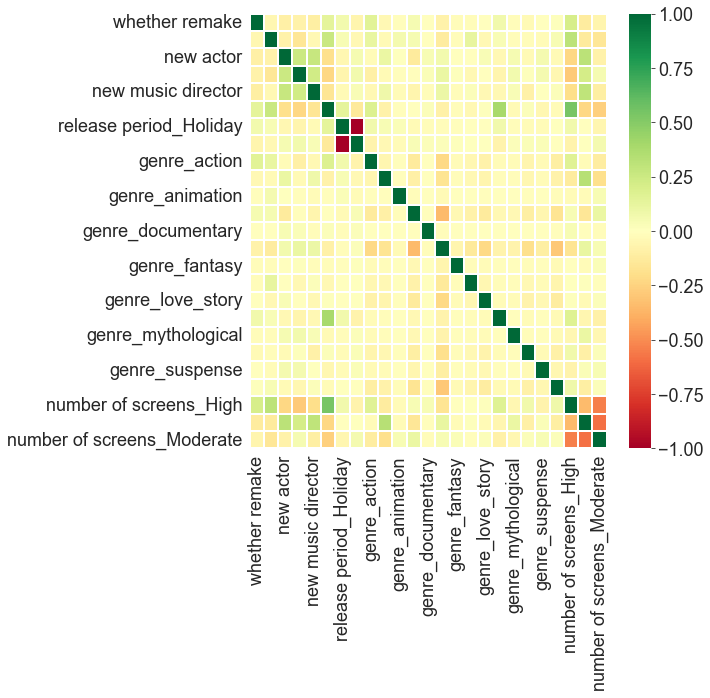

In [123]:
# correlation among the numerical variable
sns.heatmap(y.corr(), cmap ='RdYlGn', linewidths = 0.30, annot = False);

In [124]:
# standardising the budget column
y["budget(inr)"] = MinMaxScaler().fit_transform(y[["budget(inr)"]])

## Models

In [125]:
target=pd.DataFrame(x[14])
X1_train,X1_test,Y1_train,Y1_test=train_test_split(y,target,test_size=0.2,random_state=42)

### Decision tree

In [126]:
model1=DecisionTreeClassifier()
start_time=time.time()
model1.fit(X1_train,Y1_train)
end_time=time.time()
total_time=end_time-start_time
print(f"Model Accuracy is {model1.score(X1_test,Y1_test)}")
print(f"Total time taken for the model to fit is {total_time}")

Model Accuracy is 0.8970588235294118
Total time taken for the model to fit is 0.01453399658203125


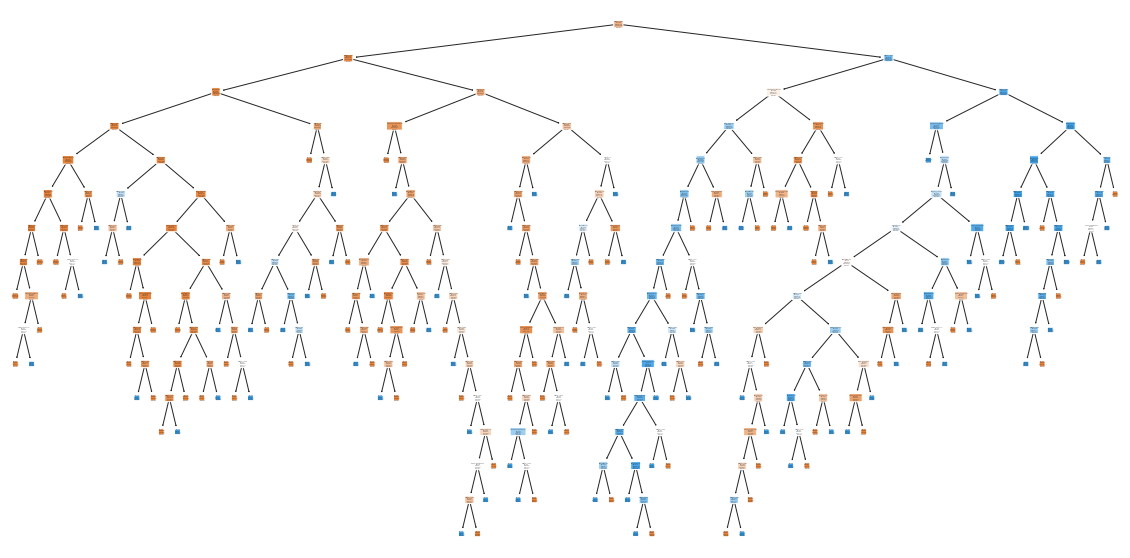

In [127]:
classes=["Hit", "Flop"]
plt.figure(figsize=(20, 10))
plot_tree(model1, filled=True, rounded=True,
          class_names=classes,
          feature_names=y.columns);

Train score 1.0
Test score 0.8970588235294118


Train Confusion matrix


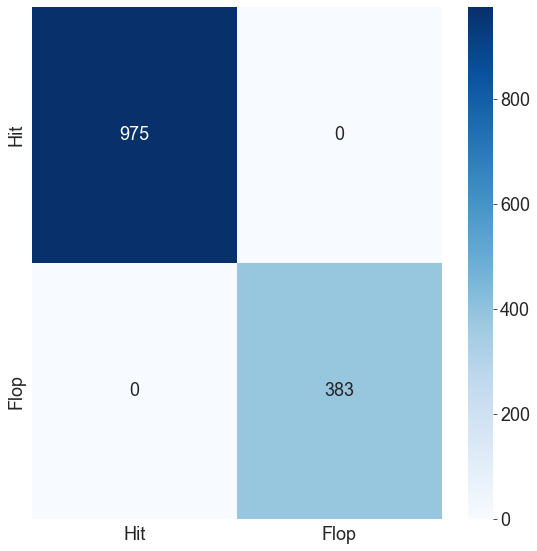

Test Confusion matrix


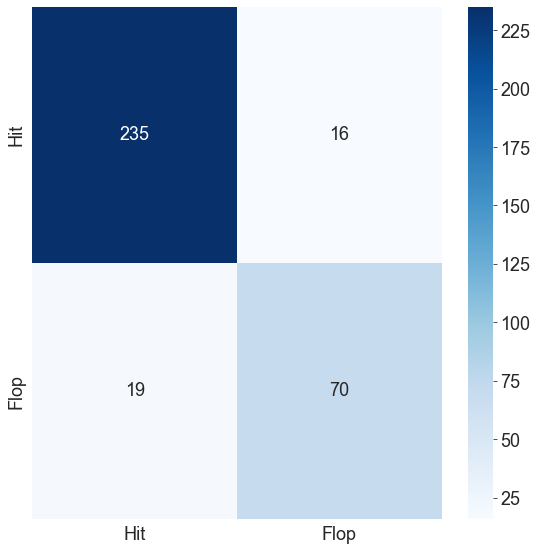

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       254
           1       0.79      0.81      0.80        86

    accuracy                           0.90       340
   macro avg       0.86      0.87      0.87       340
weighted avg       0.90      0.90      0.90       340



In [128]:
Y1_train_pred= model1.predict(X1_train)
Y1_test_pred = model1.predict(X1_test)

def plot_confusionmatrix(Y1_train_pred,Y1_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(Y1_train_pred,Y1_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
print(f'Train score {accuracy_score(Y1_train_pred,Y1_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y1_test)}')
print("\n")
plot_confusionmatrix(Y1_train_pred,Y1_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y1_test,dom='Test')
print(metrics.classification_report(Y1_test, Y1_test_pred))

#### Grid search cross validation

Train score 0.9204712812960235
Test score 0.9058823529411765
Train Confusion matrix


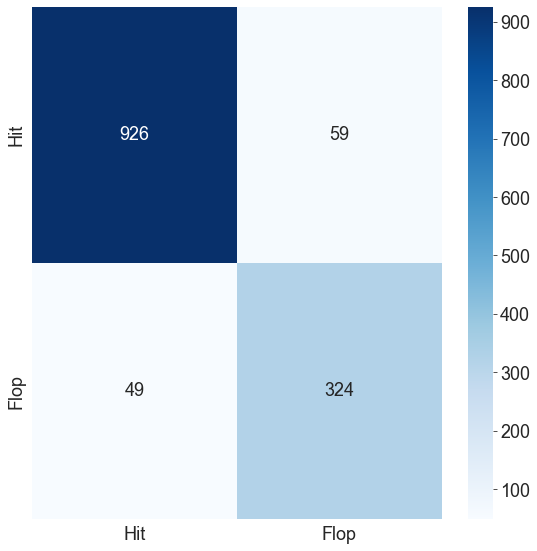

Test Confusion matrix


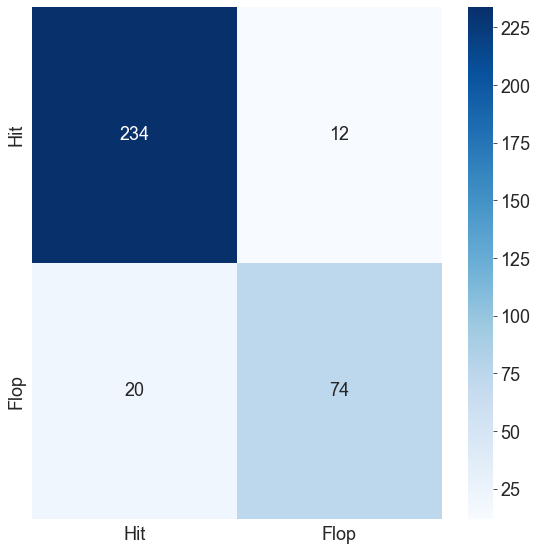

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       254
           1       0.79      0.86      0.82        86

    accuracy                           0.91       340
   macro avg       0.87      0.89      0.88       340
weighted avg       0.91      0.91      0.91       340

Total time taken for the GridSearchCv is 2.4713892936706543


In [129]:
params = {'max_depth': [2,3,4,5,6,7,8,9,10,11,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = DecisionTreeClassifier()
gcv = model_selection.GridSearchCV(estimator=clf,param_grid=params)
start_time=time.time()
gcv.fit(X1_train,Y1_train)
end_time=time.time()
total_time=end_time - start_time

cv_model = gcv.best_estimator_
cv_model.fit(X1_train,Y1_train)
Y1_train_pred = cv_model.predict(X1_train)
Y1_test_pred = cv_model.predict(X1_test)

print(f'Train score {accuracy_score(Y1_train_pred,Y1_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y1_test)}')
plot_confusionmatrix(Y1_train_pred,Y1_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y1_test,dom='Test')
print(metrics.classification_report(Y1_test, Y1_test_pred))
print(f"Total time taken for the GridSearchCv is {total_time}")

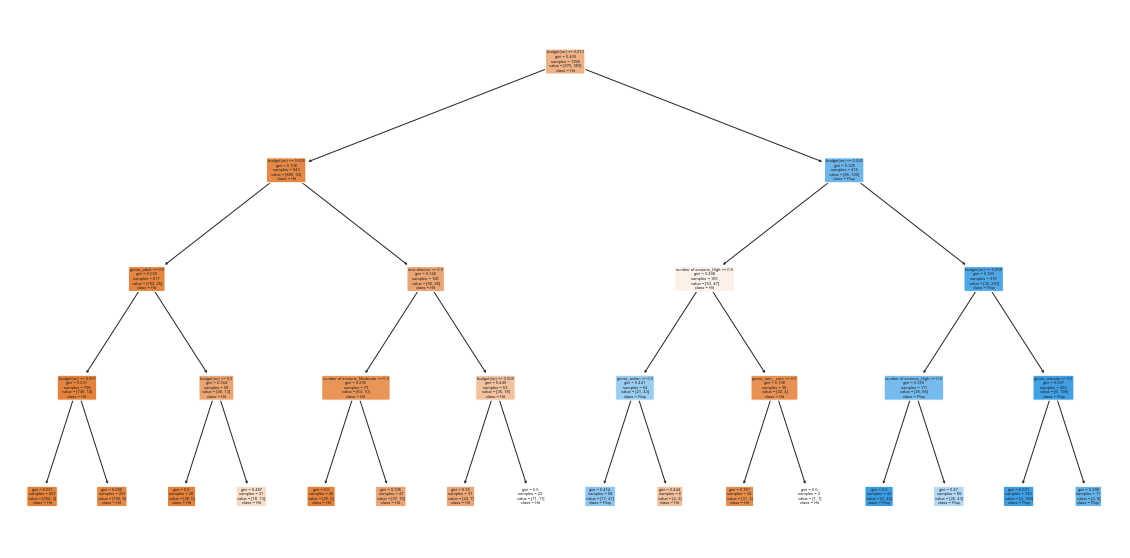

In [130]:
classes=["Flop","Hit"][::-1]
plt.figure(figsize=(20, 10))
plot_tree(cv_model, filled=True, rounded=True,
          class_names=classes,
          feature_names=X1_train.columns);

In [131]:
gcv.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [132]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(y, target, test_size=0.2)
clf = DecisionTreeClassifier(**gcv.best_params_)
%reload_ext memory_profiler
%memit clf.fit(X_train, y_train)

peak memory: 274.38 MiB, increment: 0.39 MiB


#### Cost complexity pruning

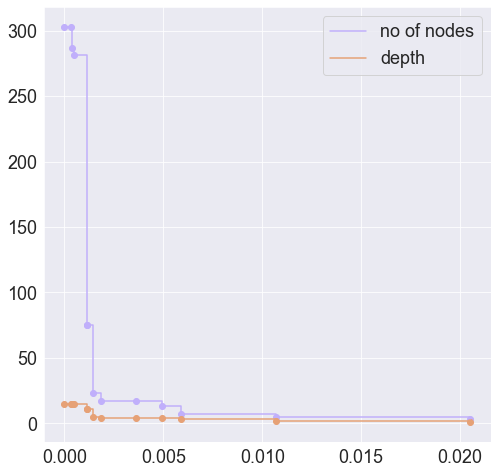

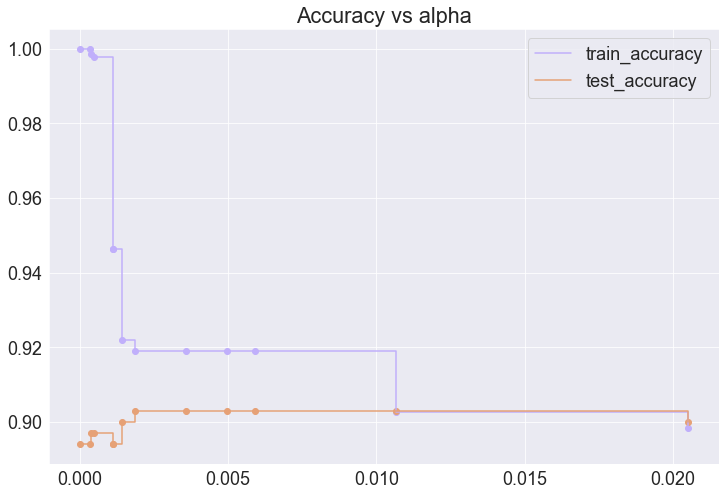

Train score 0.9189985272459499
Test score 0.9029411764705882
Train Confusion matrix


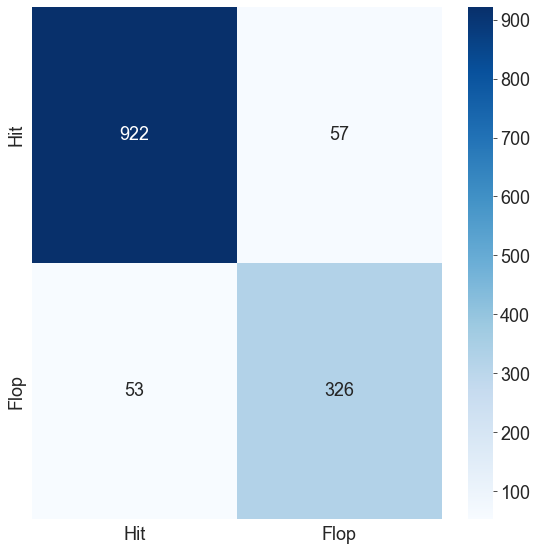

Test Confusion matrix


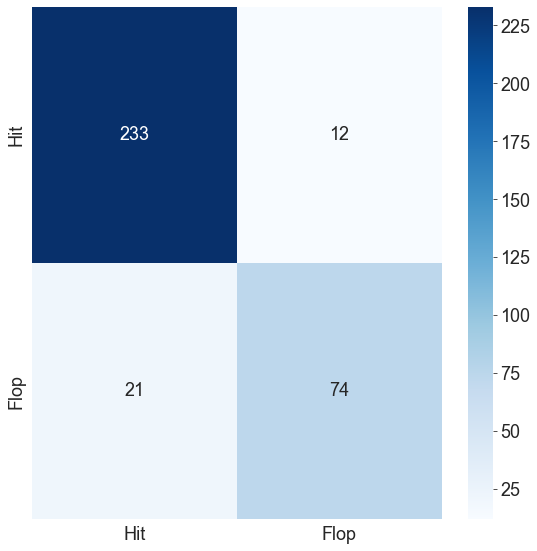

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       254
           1       0.78      0.86      0.82        86

    accuracy                           0.90       340
   macro avg       0.86      0.89      0.88       340
weighted avg       0.91      0.90      0.90       340

Total time taken for CCP is 0.10298585891723633


In [133]:
start_time=time.time()
path = clf.cost_complexity_pruning_path(X1_train, Y1_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=abs(ccp_alpha))
    clf.fit(X1_train, Y1_train)
    clfs.append(clf)
end_time=time.time()
total_time=end_time-start_time    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show();

train_acc = []
test_acc = []
for c in clfs:
    Y1_train_pred = c.predict(X1_train)
    Y1_test_pred = c.predict(X1_test)
    train_acc.append(accuracy_score(Y1_train_pred,Y1_train))
    test_acc.append(accuracy_score(Y1_test_pred,Y1_test))

plt.figure(figsize=(12, 8))
plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show();

cos_ = DecisionTreeClassifier(random_state=0,ccp_alpha=0.0105)
cos_.fit(X1_train,Y1_train)
Y1_train_pred = cos_.predict(X1_train)
Y1_test_pred = cos_.predict(X1_test)


print(f'Train score {accuracy_score(Y1_train_pred,Y1_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y1_test)}')
plot_confusionmatrix(Y1_train_pred,Y1_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y1_test,dom='Test');
print(metrics.classification_report(Y1_test, Y1_test_pred))
print(f"Total time taken for CCP is {total_time}")

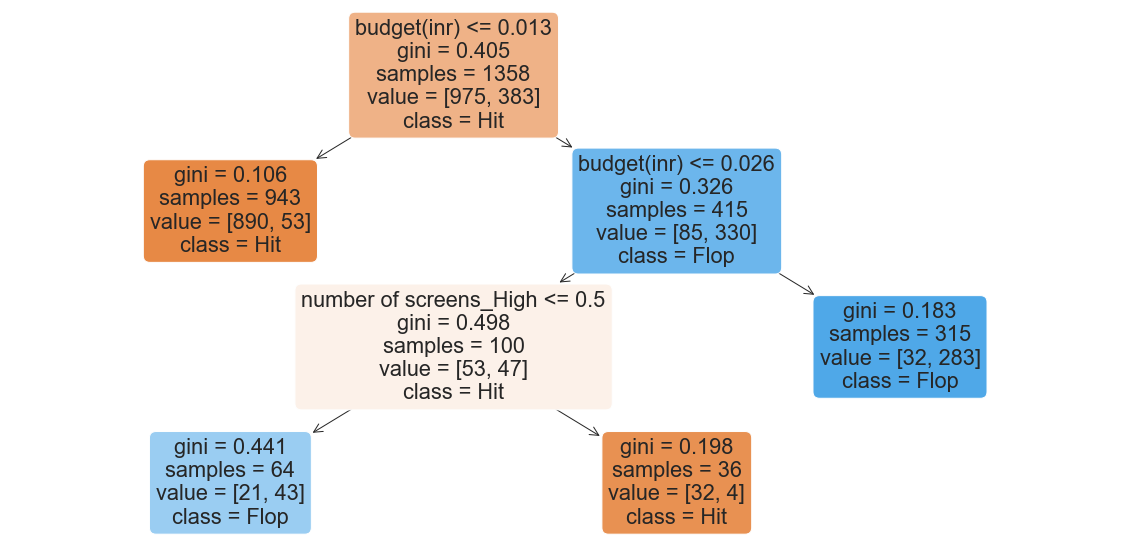

In [134]:
classes=["Hit", "Flop"]
plt.figure(figsize=(20, 10))
plot_tree(cos_, filled=True, rounded=True,
          class_names=classes,
          feature_names=X1_train.columns);

### Naive Bayes

Using Multinomial Naive Bayes since most of the categorical data has been pre processed to One_Hot_Encoding leading to binary values

In [135]:
evaluate_model(MultinomialNB, data=pd.concat([y, target], axis=1), task1=False)

MultinomialNB 

        accuracy    recall  precision  f1_score
Fold 1  0.805882  0.585106   0.670732  0.625000
Fold 2  0.826471  0.627660   0.710843  0.666667
Fold 3  0.820588  0.585106   0.714286  0.643275
Fold 4  0.805310  0.516129   0.695652  0.592593
Fold 5  0.784661  0.606383   0.612903  0.609626 

accuracy: 0.8086 +- 0.0145	 Max: 0.8265
recall: 0.5841 +- 0.0375	 Max: 0.6277
precision: 0.6809 +- 0.0373	 Max: 0.7143
f1_score: 0.6274 +- 0.0258	 Max: 0.6667

Total  average time taken for the model to fit is 0.001949310302734375


In [136]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(y, target, test_size=0.2)
clf = MultinomialNB()
%reload_ext memory_profiler
%memit clf.fit(X_train, y_train)

peak memory: 277.20 MiB, increment: 0.00 MiB
